In [36]:
from db_con import DatabaseConnection
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
from matplotlib import ticker
import contextily as cx

with DatabaseConnection() as cur:
    cur.execute("""

        --SELECT two.fn, AVG(two.ve), MAX(two.ve), MAX(two.a) filter (WHERE two.a >= 0 AND two.a != 'NaN'), MIN(two.a) filter (WHERE two.a < 0 AND two.a != 'NaN'),
        --    CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END
        --    FROM (
        --        SELECT filename as fn, unnest(timestamps) as ts, unnest(velos) as ve, unnest(accels) as a FROM ride
        --    ) as two WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

        SELECT two.fn, AVG(two.ve), MAX(two.ve), MAX(a1.accel), MIN(d1.accel), CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END FROM (
        SELECT one.fn as fn, unnest(one.t) as ts, unnest(one.v) as ve FROM (
        SELECT filename as fn, timestamps as t, distances as d, velos as v, (((ST_Points(geom::geometry))::json) -> 'coordinates') as pts from ride
        ) as one
        ) as two LEFT JOIN accels a1 ON (two.fn = a1.filename AND two.ts = a1.timestamp AND a1.accel >= 0)
                 LEFT JOIN accels d1 ON (two.fn = d1.filename AND two.ts = d1.timestamp AND d1.accel < 0)
                 WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

    """)
    objs = cur.fetchall()


In [37]:
import numpy as np
import scipy.stats as st

pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group'])

pdf_avg_0 = pdf_all.query('group == 0')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_0 = pdf_all.query('group == 0')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_0 = pdf_all.query('group == 0 and max_accel >= 0')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_0 = pdf_all.query('group == 0 and max_decel < 0')[['file', 'max_decel']].sort_values('max_decel').reset_index()

pdf_avg_1 = pdf_all.query('group == 1')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_1 = pdf_all.query('group == 1')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_1 = pdf_all.query('group == 1 and max_accel >= 0')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_1 = pdf_all.query('group == 1 and max_decel < 0')[['file', 'max_decel']].sort_values('max_decel').reset_index()

pdf_avg_2 = pdf_all.query('group == 2')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_2 = pdf_all.query('group == 2')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_2 = pdf_all.query('group == 2 and max_accel >= 0')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_2 = pdf_all.query('group == 2 and max_decel < 0')[['file', 'max_decel']].sort_values('max_decel').reset_index()

b1 = 15.71#3.6 * pdf_avg.iloc[int(0.25 * len(pdf_avg))]['avg_speed']
b2 = 20.41#3.6 * pdf_avg.iloc[int(0.75 * len(pdf_avg))]['avg_speed']

def plot_graph(pdf_local: pd.Series, label_name: str, vlines: bool):
    mn, mx = plt.xlim()
    n_bins = 200
    plt.hist(pdf_local * 3.6, n_bins, range=(mn, mx), density=False, histtype='step')
    kde_xs = np.linspace(mn, mx, 200)
    kde_avg = st.gaussian_kde(pdf_local * 3.6)#put data in linear regression -> plot formula
    plt.plot(kde_xs, ((mx - mn) / n_bins * len(pdf_local)) * kde_avg.pdf(kde_xs), label=label_name)

    if vlines:
        plt.vlines([3.6 * pdf_local.iloc[int(0.25 * len(pdf_local))], 3.6 * pdf_local.iloc[int(0.75 * len(pdf_local))]], 0, 0.125)

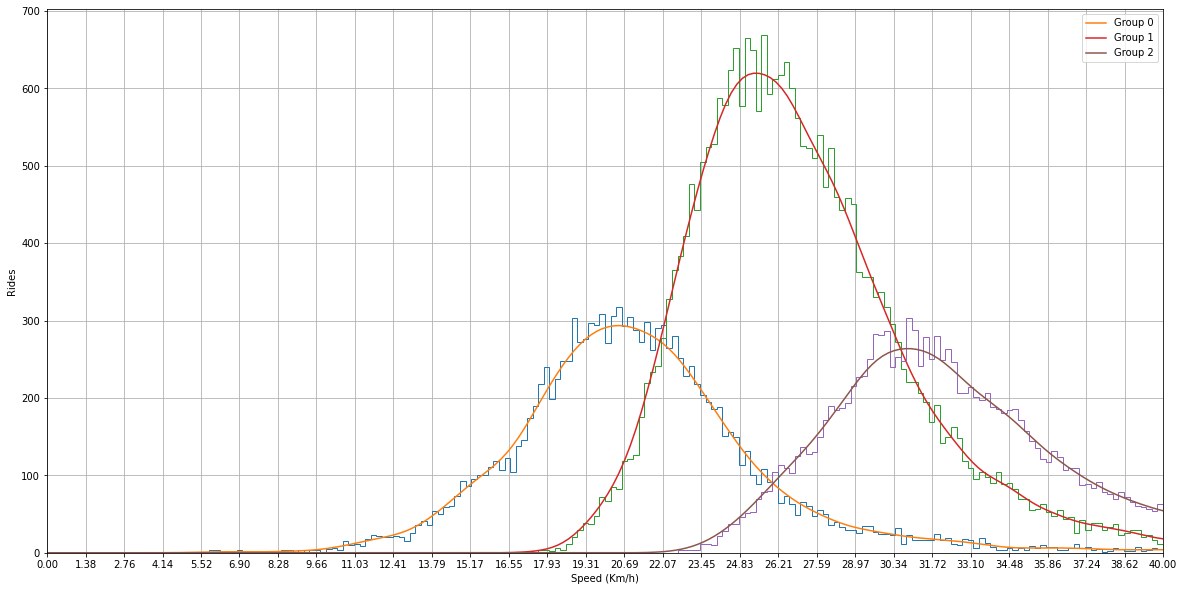

In [38]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Speed (Km/h)')
plt.xlim(0, 40)

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_max_0['max_speed'], "Group 0", False)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
plot_graph(pdf_max_1['max_speed'], "Group 1", False)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
plot_graph(pdf_max_2['max_speed'], "Group 2", False)

plt.legend()
plt.show()

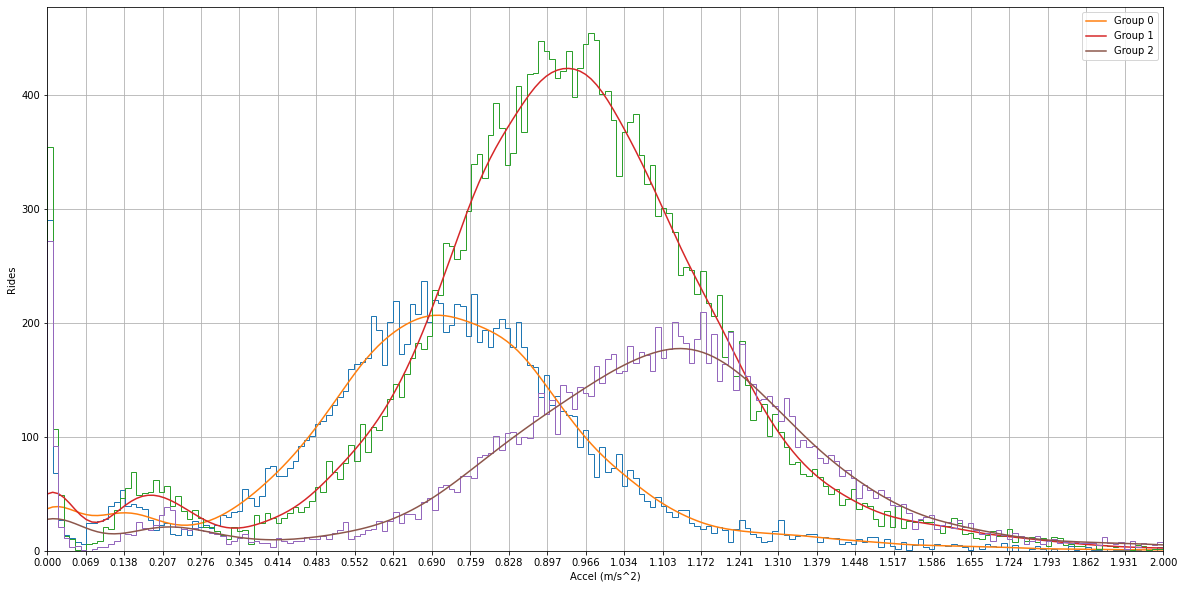

In [40]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Accel (m/s^2)')
plt.xlim(0, 2)

#plot_graph(pdf_all['max_accel'] / 3.6, "All", False)
plot_graph(pdf_acc_0['max_accel'] / 3.6, "Group 0", False)
plot_graph(pdf_acc_1['max_accel'] / 3.6, "Group 1", False)
plot_graph(pdf_acc_2['max_accel'] / 3.6, "Group 2", False)

plt.legend()
plt.show()

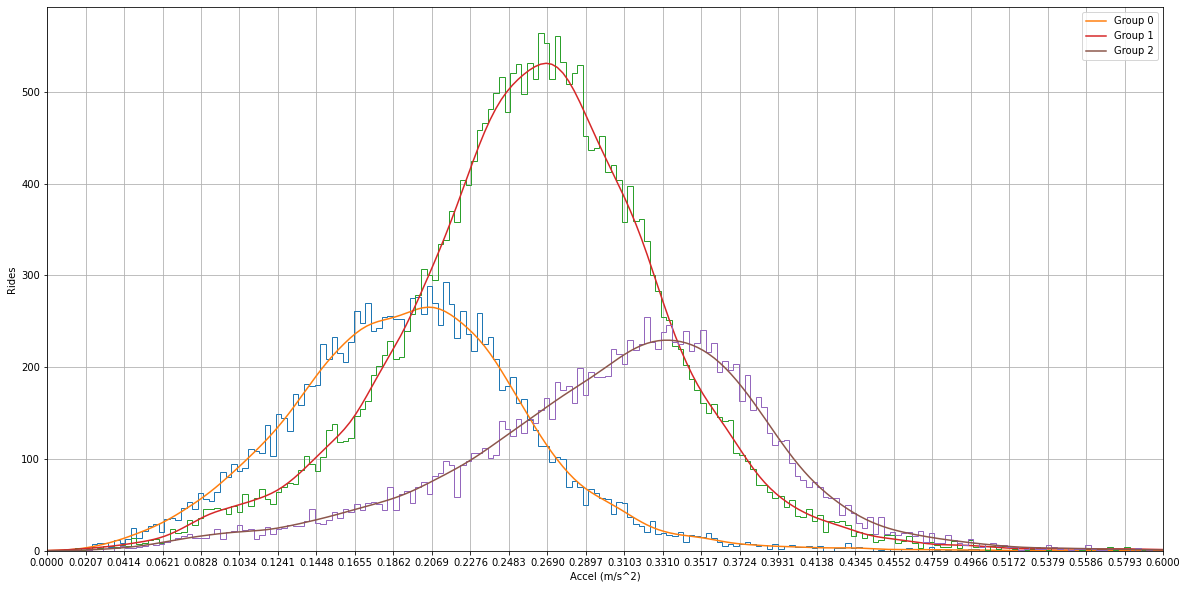

In [34]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Accel (m/s^2)')
plt.xlim(0, 0.6)

#plot_graph(pdf_all['max_accel'] / 3.6, "All", False)
plot_graph(pdf_acc_0['max_accel'] / 3.6, "Group 0", False)
plot_graph(pdf_acc_1['max_accel'] / 3.6, "Group 1", False)
plot_graph(pdf_acc_2['max_accel'] / 3.6, "Group 2", False)

plt.legend()
plt.show()

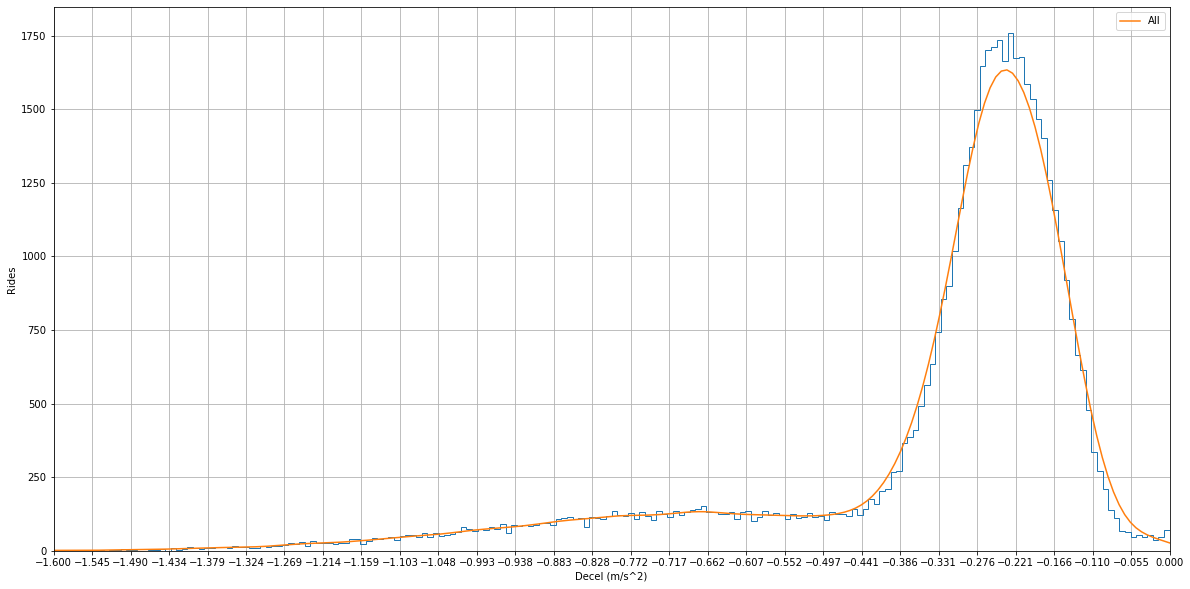

In [42]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Decel (m/s^2)')
plt.xlim(-1.6, 0)

plot_graph(pdf_all['max_decel'][lambda x: x < 0] / 3.6, "All", False)
#plot_graph(pdf_dec_0['max_decel'] / 3.6, "Group 0", False)
#plot_graph(pdf_dec_1['max_decel'] / 3.6, "Group 1", False)
#plot_graph(pdf_dec_2['max_decel'] / 3.6, "Group 2", False)

plt.legend()
plt.show()

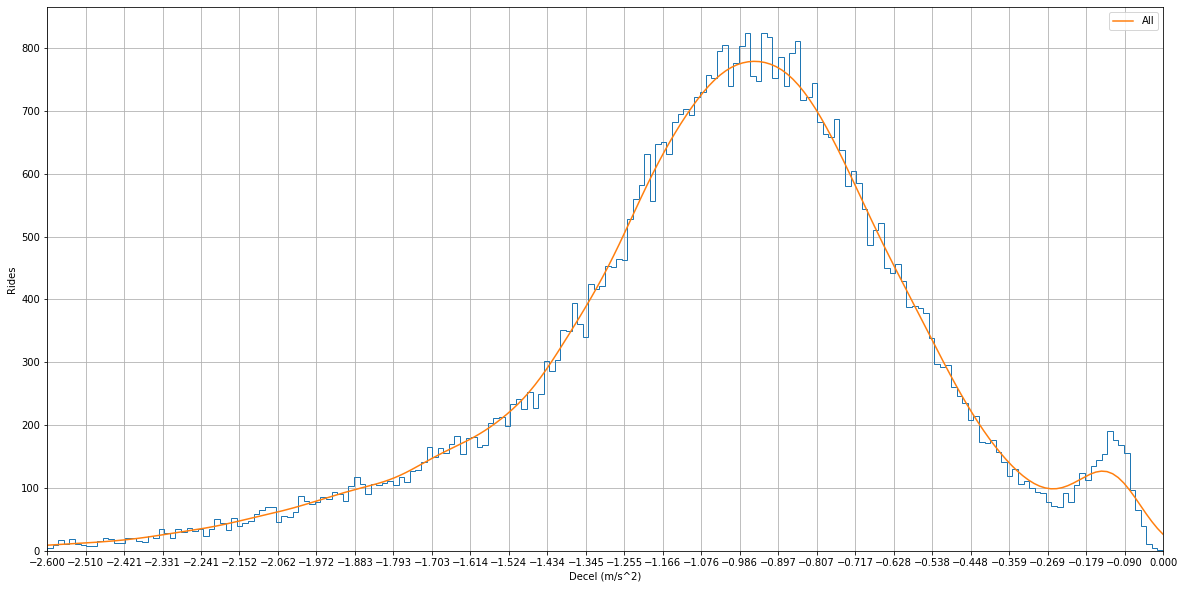

In [35]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Decel (m/s^2)')
plt.xlim(-2.6, 0)

plot_graph(pdf_all['max_decel'][lambda x: x < 0] / 3.6, "All", False)
#plot_graph(pdf_dec_0['max_decel'] / 3.6, "Group 0", False)
#plot_graph(pdf_dec_1['max_decel'] / 3.6, "Group 1", False)
#plot_graph(pdf_dec_2['max_decel'] / 3.6, "Group 2", False)

plt.legend()
plt.show()

In [27]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT two.fn, two.ts, two.ve FROM (
        SELECT one.fn as fn, unnest(one.t) as ts, unnest(one.v) as ve FROM (
        SELECT filename as fn, timestamps as t, distances as d, velos as v, (((ST_Points(geom::geometry))::json) -> 'coordinates') as pts from ride OFFSET 9 LIMIT 1
        ) as one
        ) as two WHERE two.ve != 'NaN' AND two.ve < 15 ORDER BY two.ts ASC

    """)
    objs_one = cur.fetchall()

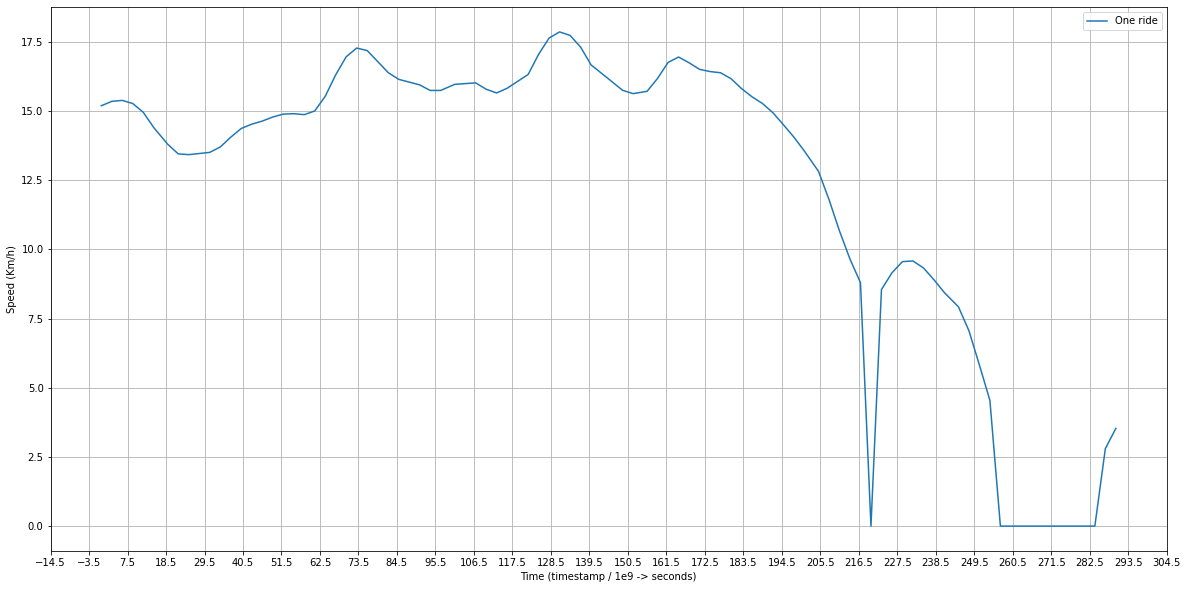

In [28]:
pdf_one = pd.DataFrame(objs_one, columns=['file', 'time', 'speed'])

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Speed (Km/h)')
ax.set_xlabel('Time (timestamp / 1e9 -> seconds)')
#plt.xlim(0, 200)

plt.plot(pdf_one['time'].map(lambda v: (v.value - pdf_one['time'][0].value) / 1e9), pdf_one['speed'] * 3.6, label="One ride")

plt.legend()
plt.show()

In [57]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT three.fn, AVG(three.vf), AVG(three.vl) FROM (
        SELECT two.fn as fn, unnest(two.ve[1:3]) as vf, unnest(two.ve[array_length(two.ve, 1) - 2:array_length(two.ve, 1)]) as vl FROM (
        SELECT filename as fn, array_remove(velos, 'NaN') as ve FROM ride
        ) as two
        ) three GROUP BY three.fn

    """)
    objs_start_spd = cur.fetchall()

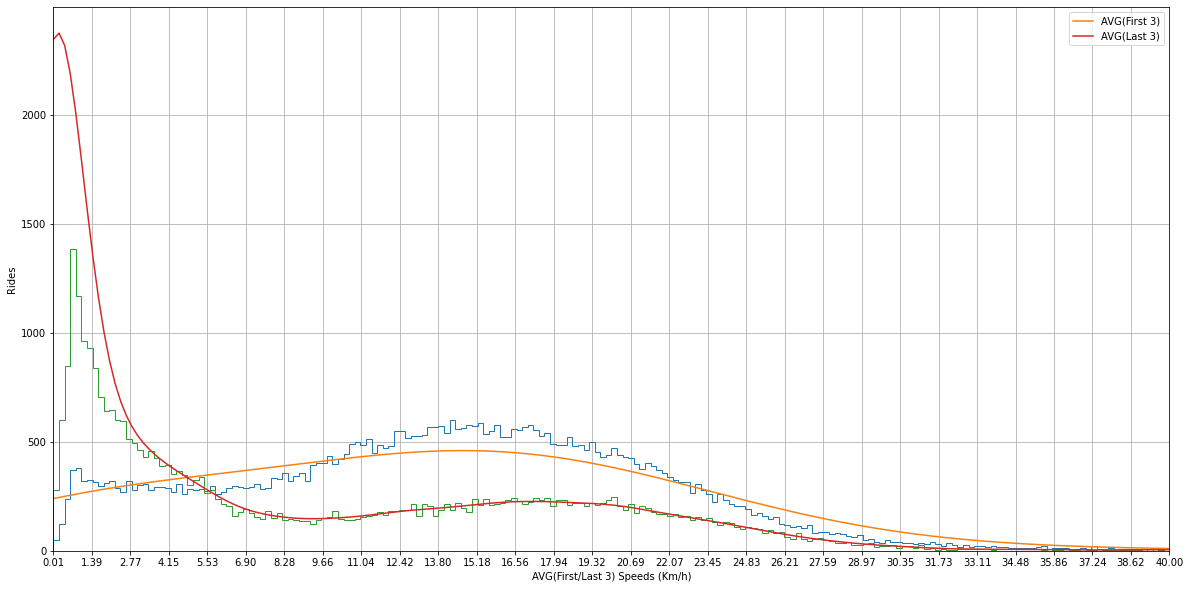

In [58]:
pdf_start_spd = pd.DataFrame(objs_start_spd, columns=['file', 'avg_speed_e', 'avg_speed_l'])

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('AVG(First/Last 3) Speeds (Km/h)')
plt.xlim(0.01, 40)

plot_graph(pdf_start_spd['avg_speed_e'], "AVG(First 3)", False)
plot_graph(pdf_start_spd['avg_speed_l'], "AVG(Last 3)", False)

plt.legend()
plt.show()

In [28]:
with DatabaseConnection() as cur:
    cur.execute("""

        --SELECT two.fn, AVG(two.ve), MAX(two.ve),
        --    AVG(two.a) filter (WHERE two.a >= 0 AND two.a != 'NaN'), MAX(two.a) filter (WHERE two.a >= 0 AND two.a != 'NaN'),
        --    AVG(two.a) filter (WHERE two.a < 0 AND two.a != 'NaN'), MIN(two.a) filter (WHERE two.a < 0 AND two.a != 'NaN'),
        --    CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END
        --    FROM (
        --        SELECT filename as fn, unnest(timestamps) as ts, unnest(velos) as ve, unnest(accels) as a FROM ride
        --    ) as two WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

        SELECT two.fn, AVG(two.ve), MAX(two.ve), AVG(a1.accel), MAX(a1.accel), AVG(d1.accel), MIN(d1.accel), CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END FROM (
        SELECT one.fn as fn, unnest(one.t) as ts, unnest(one.v) as ve FROM (
        SELECT filename as fn, timestamps as t, distances as d, velos as v, (((ST_Points(geom::geometry))::json) -> 'coordinates') as pts from ride
        ) as one
        ) as two LEFT JOIN accels a1 ON (two.fn = a1.filename AND two.ts = a1.timestamp AND a1.accel >= 0)
                 LEFT JOIN accels d1 ON (two.fn = d1.filename AND two.ts = d1.timestamp AND d1.accel < 0)
                 WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

    """)
    objs_corr = cur.fetchall()

/usr/local/lib/python3.8/dist-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


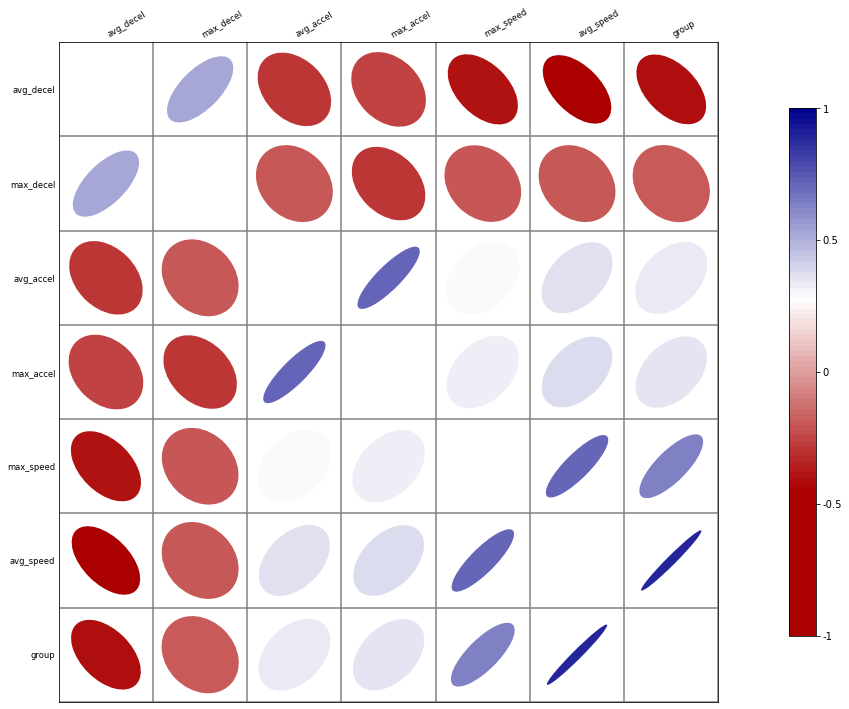

In [29]:
from pyensae.graphhelper import Corrplot

df_corr = pd.DataFrame(objs_corr, columns=['file', 'avg_speed', 'max_speed', 'avg_accel', 'max_accel', 'avg_decel', 'max_decel', 'group']).drop(columns=['file'])

c = Corrplot(df_corr)
c.plot(figsize=(20,10))

plt.show()

In [ ]:
import numpy as np
import scipy.stats as st

#pdf = pd.DataFrame(objs, columns=['file', 'velo']).query('velo > 0.2 and velo != "NaN" and velo < 15')

#groupd = pdf.groupby('file').aggregate({'velo': np.average}).rename(columns={'velo': 'avg_speed'})

#pdf = groupd #pdf.merge(groupd, how='inner', on='file')

pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'group'])#.sort_values('avg_speed').reset_index()

pdf_avg_0 = pdf_all.query('group == 0')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_0 = pdf_all.query('group == 0')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_0 = pdf_all.query('group == 0')[['file', 'max_accel']].sort_values('max_accel').reset_index()

pdf_avg_1 = pdf_all.query('group == 1')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_1 = pdf_all.query('group == 1')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_1 = pdf_all.query('group == 1')[['file', 'max_accel']].sort_values('max_accel').reset_index()

pdf_avg_2 = pdf_all.query('group == 2')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_2 = pdf_all.query('group == 2')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_2 = pdf_all.query('group == 2')[['file', 'max_accel']].sort_values('max_accel').reset_index()

b1 = 15.71#3.6 * pdf_avg.iloc[int(0.25 * len(pdf_avg))]['avg_speed']
b2 = 20.41#3.6 * pdf_avg.iloc[int(0.75 * len(pdf_avg))]['avg_speed']
#c1 = 3.6 * pdf_max.iloc[int(0.25 * len(pdf_max))]['max_speed']
#c2 = 3.6 * pdf_max.iloc[int(0.75 * len(pdf_max))]['max_speed']

print(b1)
print(b2)

#pdf_g = pd.DataFrame([[1, 2, 3], [1, 5, 6], [2, 2, 4], [2, 5, 7]], columns=['a', 'b', 'c'])

#groupd = pdf_g.groupby('a').aggregate({'b': np.average, 'c': np.average}).rename(columns={'b': 'b_avg', 'c': 'c_avg'})

#print(groupd.query('a == 1'))

#print(groupd)

#print(pdf_g.merge(groupd, how='inner', on='a'))

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
#ax.set_xlabel('Speed (Km/h)')
ax.set_xlabel('Accel (m/s^2)')

#ax.vlines([b1, b2], 0, 0.125)
#ax.vlines([c1, c2], 0, 0.125)

def plot_graph(pdf_local: pd.Series, vlines: bool):
    mn, mx = plt.xlim()
    n_bins = 200
    plt.hist(pdf_local * 3.6, n_bins, range=(mn, mx), density=False, histtype='step')
    kde_xs = np.linspace(mn, mx, 200)
    kde_avg = st.gaussian_kde(pdf_local * 3.6)
    plt.plot(kde_xs, ((mx - mn) / n_bins * len(pdf_local)) * kde_avg.pdf(kde_xs), label="PDF")

    if vlines:
        ax.vlines([3.6 * pdf_local.iloc[int(0.25 * len(pdf_local))], 3.6 * pdf_local.iloc[int(0.75 * len(pdf_local))]], 0, 0.125)


#plt.hist(pdf_avg['avg_speed'] * 3.6, 200, density=True, histtype='step')
#plt.hist(pdf_max['max_speed'] * 3.6, 200, density=True, histtype='step')
#plt.plot(pdf.sort_values('avg_speed').reset_index()['avg_speed'])

#plt.ylim([0, 10])

#mn, mx = plt.xlim()
#plt.xlim(mn, mx)
plt.xlim(-0.1, 2)
#kde_xs = np.linspace(mn, mx, 200)
#kde_avg = st.gaussian_kde(pdf_avg['avg_speed'] * 3.6)
#kde_max = st.gaussian_kde(pdf_max['max_speed'] * 3.6)
#plt.plot(kde_xs, kde_avg.pdf(kde_xs), label="PDF")
#plt.plot(kde_xs, kde_max.pdf(kde_xs), label="PDF")

#plot_graph(pdf_avg_0['avg_speed'], False)
#plot_graph(pdf_max_0['max_speed'], False)
plot_graph(pdf_acc_0['max_accel'] / 3.6, False)

#plot_graph(pdf_avg_1['avg_speed'], False)
#plot_graph(pdf_max_1['max_speed'], False)
plot_graph(pdf_acc_1['max_accel'] / 3.6, False)

#plot_graph(pdf_avg_2['avg_speed'], False)
#plot_graph(pdf_max_2['max_speed'], False)
plot_graph(pdf_acc_2['max_accel'] / 3.6, False)

plt.show()